# Predictive Modelling of Eating-Out

<div class="callout note">
  <p><strong>Overview</strong></p>

The objective of this study is to predict restaurant ratings using both regression and classification approaches. The process begins with exploratory data analysis, followed by data preprocessing steps such as handling missing values, encoding, and scaling, along with feature enrichment. A variety of models are then trained and evaluated, including scikit-learn’s linear regression, logistic regression, Random Forests, Gradient Boosting, Support Vector Machines, and Multilayer Perceptrons. Additionally, PySpark MLlib’s regression and logistic models are compared with their scikit-learn counterparts in terms of accuracy, scalability, and runtime performance.

The directory where this Jupyter notebook (`A1.ipynb`) resides is such:
  <ul>
    <li><em>zomato_df_final_data.csv</em> and <em>sydney.geojson</em> reside in the <code>data</code> directory.</li>
    <li><em>logr_model.pkl</em> is written to the <code>outputs</code> directory, which is created automatically if missing.</li>
    <li>All paths are relative to the notebook to prevent <em>Papermill</em> errors during pipeline execution.</li>
  </ul>
</p>
<p>
<strong>Pipeline and Collaborators</strong>
    
The developer will commit the changes locally and push to remote with the intention that other collabators can use it.
Accompanied the machine learning notebook are the pipeline and collaborators notebook. 
  <ul>
    <li>`A1_pipeline.ipynb` - Developer will run this notebook to invoke the entire pipeline. Only changes commited to locally will be pushed to the remote repository.</li>
    <li>`A1_collaborator.ipynb` - Another collaborator (can be co-workers from other team) will run this notebook to clone and re-run the pipeline in their respectiv environments.</li>
  </ul>
</p>
<p>
<strong>Caveats</strong>

Because the encoded dataset is sparse, model training can be time-consuming. The experiments are conducted on a machine configured with the following specifications (with 114,771,748 kB memory):
<ul>
  <li>Architecture:                            x86_64</li>
  <li>CPU op-mode(s):                          32-bit, 64-bit</li>
  <li>Address sizes:                           45 bits physical, 48 bits virtual</li>
  <li>Byte Order:                              Little Endian</li>
  <li>CPU(s):                                  8</li>
  <li>On-line CPU(s) list:                     0-7</li>
  <li>Vendor ID:                               GenuineIntel</li>
  <li>Model name:                              Intel(R) Xeon(R) E-2186M  CPU @ 2.90GHz</li>
  <li>CPU family:                              6</li>
  <li>Model:                                   158</li>
  <li>Thread(s) per core:                      1</li>
  <li>Core(s) per socket:                      1</li>
</ul>
</p>
</div>

In [1]:
# noop 1
from IPython.display import HTML, display
from pathlib import Path
p = Path("~/.jupyter/custom.css").expanduser()
if p.exists():
    display(HTML(f"<style>{p.read_text()}</style>"))

### <font color='navy'>Checking Package versions</font>

In [2]:
from importlib.metadata import version
import platform
from IPython import get_ipython
ip = get_ipython()


print("Python:", platform.python_version())
for dist in ["pandas", "numpy", "matplotlib", "seaborn", "plotly",
            "scikit-learn", "pyspark", "dvc", "jupyterlab",
             "jupyterlab-git", "pre-commit", "nbstripout", "pip", "geopandas"]:
    print(f"{dist}:", version(dist))

# Conda/Mamba, git and Java versions
conda_ver  = ip.getoutput("conda --version 2>&1") if ip else []
mamba_ver  = ip.getoutput("mamba --version 2>&1") if ip else []
git_ver = ip.getoutput("git --version 2>&1") if ip else []
java_ver = ip.getoutput("java -version 2>&1") if ip else []
print("---")
print("conda:",       (conda_ver[0] if conda_ver else "NOT INSTALLED or no output"))
print("mamba:",       (mamba_ver[0] if mamba_ver else "NOT INSTALLED or no output"))
print("git:", (git_ver[0] if git_ver else "NOT INSTALLED or no output"))
print("Java (OpenJDK):", (java_ver[0] if java_ver else "NOT INSTALLED or no output"))

Python: 3.12.11
pandas: 2.3.2
numpy: 2.3.3
matplotlib: 3.10.6
seaborn: 0.13.2
plotly: 6.3.0
scikit-learn: 1.7.2
pyspark: 4.0.0
dvc: 3.63.0
jupyterlab: 4.4.8
jupyterlab-git: 0.51.2
pre-commit: 4.3.0
nbstripout: 0.8.1
pip: 25.2
geopandas: 1.1.1
---
conda: conda 25.3.1
mamba: 2.1.1
git: git version 2.51.0
Java (OpenJDK): openjdk version "21.0.8-internal" 2025-07-15


### <font color='navy'>Import Packages</font>

In [3]:
# Import all necessary packages to predict Eating-Out Problem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import geopandas as gpd
import pyproj
import plotly.express as px
import os
import seaborn as sns
import time
from pathlib import Path
import joblib

# Part A – Exploratory Data Analysis

<div class="callout note">
  <p><strong>Part A.1. Load and explore the dataset</strong></p>
<p>
<strong>Part A.1.1. Missing Values</strong>

Rating fields (<code>rating_number</code>, <code>votes</code>, <code>rating_text</code>) appear in 7,184 of 10,500 records which is approximately 32% missing. As rating_number and rating_text will be used as targets for regression and classification later so only the non-missing corresponding rows in the features can be used as a way to handle substantial missingness. Geocoordinates are nearly complete (lat/lng in 10,308 rows with approximately 98% coverage) and <code>cost</code> and <code>cost_2</code> are available for 10,154 (with 192 missing) rows.
</p>
<p>
<strong>Part A.1.2. Data Types</strong>
    
Types of features
<ul>
  <li>Numeric: <code>cost</code>, <code>cost_2</code>, <code>lat</code>, <code>lng</code>, <code>rating_number</code>, <code>votes</code>.</li>
  <li>Categorical: <code>address</code>, <code>cuisine</code>, <code>link</code>, <code>phone</code>, <code>rating_text</code>, <code>subzone</code>, <code>title</code>, <code>type</code>, <code>color</code>, <code>cuisine_color</code>.</li>
    <ul>
        <li>Ordinal - <code>rating_text</code>  (e.g.,Poor < Average < Good < Very Good < Excellent) </li>
    </ul>
</ul>
</p>
<p>
<strong>Part A.1.3. Summary Statistics</strong>

<code>cost</code> (n=10,154) is centered around 45–60 with a mean of 51.2 and a long right tail up to 500. Its scaled version, <code>cost_2</code> reflects this but on a smaller scale (median a pprox. 4.86, IQR approx. 3.70–6.02, max 40). Ratings are moderately positive (rating_number, n=7,184) with mean 3.28 and IQR 3.0–3.6 (range 1.8–4.9). Engagement is highly skewed (votes, n=7,184): median 32 (IQR 12–87), mean 83.6, and a heavy tail reaching 3,236.
</p>
</div>

### <font color='navy'>Part A.1. Load and explore the dataset</font>

In [4]:
# parameters
DATA_CSV = "data/zomato_df_final_data.csv"
MODEL_OUT = "outputs/logr_model.pkl"

In [5]:
# Paths required by Papermill
DATA_CSV = Path(DATA_CSV)
MODEL_OUT = Path(MODEL_OUT)
# Papermill will inject DATA_CSV; fall back to relative path for interactive runs
try:
    DATA_CSV
except NameError:
    DATA_CSV = "data/zomato_df_final_data.csv"

DATA_CSV = Path(DATA_CSV)          # resolve later if needed
BASE = str(DATA_CSV.parent) + "/"  # "data/"
df = pd.read_csv(DATA_CSV)
df.head(3)

,address,cost,cuisine,lat,link,lng,phone,rating_number,rating_text,subzone,title,type,votes,groupon,color,cost_2,cuisine_color
0,"371A Pitt Street, CBD, Sydney",50.0,"['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean']",-33.876059,https://www.zomato.com/sydney/sydney-madang-cbd,151.207605,02 8318 0406,4.0,Very Good,CBD,Sydney Madang,['Casual Dining'],1311.0,False,#e15307,5.243902,#6f706b
1,"Shop 7A, 2 Huntley Street, Alexandria, Sydney",80.0,"['Cafe', 'Coffee and Tea', 'Salad', 'Poké']",-33.910999,https://www.zomato.com/sydney/the-grounds-of-a...,151.193793,02 9699 2225,4.6,Excellent,"The Grounds of Alexandria, Alexandria",The Grounds of Alexandria Cafe,['Café'],3236.0,False,#9c3203,7.560976,#6f706b
2,"Level G, The Darling at the Star, 80 Pyrmont ...",120.0,['Japanese'],-33.867971,https://www.zomato.com/sydney/sokyo-pyrmont,151.195210,1800 700 700,4.9,Excellent,"The Star, Pyrmont",Sokyo,['Fine Dining'],1227.0,False,#7f2704,10.650407,#6f706b


#### Part A.1.1. Missing Values

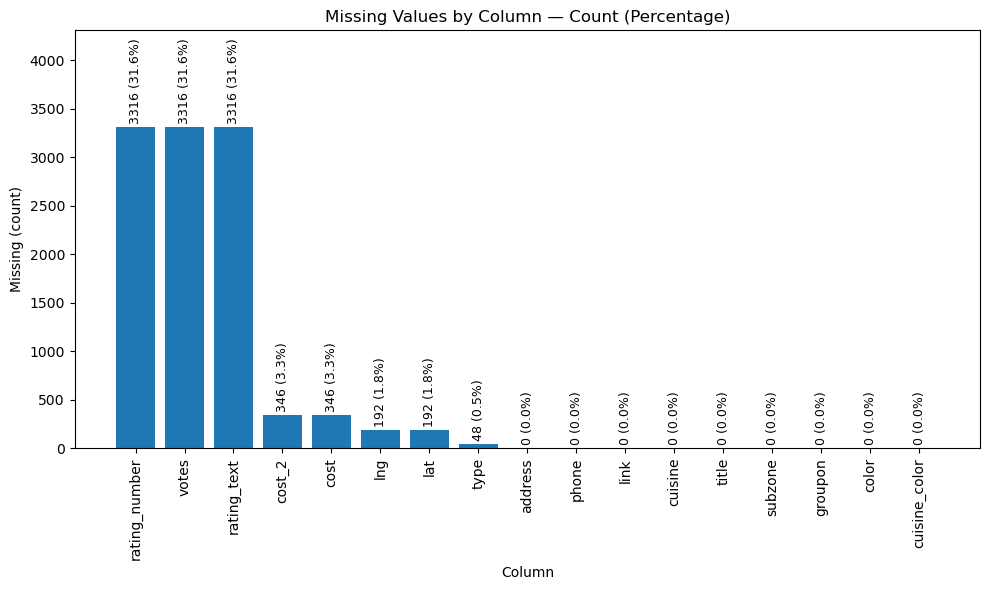

In [6]:
# Missing counts & percentages
missing_counts = df.isna().sum()
missing_percent = (missing_counts / len(df) * 100)

# Order by highest % missing (desc)
order = missing_percent.sort_values(ascending=False).index
counts_ord = missing_counts.loc[order]
percent_ord = missing_percent.loc[order]

# Labels "count (percentage)"
labels = [f"{c:.0f} ({p:.1f}%)" for c, p in zip(counts_ord.values, percent_ord.values)]

# Plot
fig, ax = plt.subplots(figsize=(max(10, 0.5 * len(order)), 6))
bars = ax.bar(order.astype(str), counts_ord.values)
ax.set_title("Missing Values by Column — Count (Percentage)")
ax.set_ylabel("Missing (count)")
ax.set_xlabel("Column")
ax.tick_params(axis="x", rotation=90)

# Add labels on top of each bar
ax.bar_label(bars, labels=labels, padding=2, rotation=90, fontsize=9)

# --- Headroom tuning: raise the top so labels don't clip ---
max_count = counts_ord.max()
PAD_FRAC = 0.25   # fraction of the max height to add as headroom
PAD_MIN  = 3.0    # minimum absolute headroom (in data units)
top = max_count + max(PAD_MIN, PAD_FRAC * max_count)
ax.set_ylim(0, counts_ord.max() + max(3.0, 0.30 * counts_ord.max()))

plt.tight_layout()
plt.show()

#### Part A.1.2. Data Types

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   address        10500 non-null  object 
 1   cost           10154 non-null  float64
 2   cuisine        10500 non-null  object 
 3   lat            10308 non-null  float64
 4   link           10500 non-null  object 
 5   lng            10308 non-null  float64
 6   phone          10500 non-null  object 
 7   rating_number  7184 non-null   float64
 8   rating_text    7184 non-null   object 
 9   subzone        10500 non-null  object 
 10  title          10500 non-null  object 
 11  type           10452 non-null  object 
 12  votes          7184 non-null   float64
 13  groupon        10500 non-null  bool   
 14  color          10500 non-null  object 
 15  cost_2         10154 non-null  float64
 16  cuisine_color  10500 non-null  object 
dtypes: bool(1), float64(6), object(10)
memory usage: 1

#### Part A.1.3. Summary Statistics

In [8]:
summary = df.select_dtypes(include=["number"]).describe(include="all").transpose()
print(summary.to_string())

                 count        mean         std         min         25%         50%         75%          max
cost           10154.0   51.153240   27.799485    8.000000   30.000000   45.000000   60.000000   500.000000
lat            10308.0  -32.921377    8.263449  -37.858473  -33.899094  -33.872741  -33.813451    51.500986
lng            10308.0  148.067359   26.695402 -123.270371  151.061061  151.172468  151.208940   152.869052
rating_number   7184.0    3.283672    0.454580    1.800000    3.000000    3.300000    3.600000     4.900000
votes           7184.0   83.581013  175.117966    4.000000   12.000000   32.000000   87.000000  3236.000000
cost_2         10154.0    5.332974    2.147115    2.000000    3.699187    4.857724    6.016260    40.000000


<div class="callout note">
  <p><strong>Part A.2. Answer with plots/graphs and descriptions</strong></p>
<p>
<strong>Part A.2.1 How many unique cuisines are served?</strong>
</p>
<p>
<strong>Part A.2.2. Which 3 suburbs have the most restaurants?</strong>
    
From the top 10 suburbs that have most restaurant, CBD (476), Surry Hills (260) and Parramatta (225) have the most restaurants.
</p>
<p>
<strong>Part A.2.3. Are restaurants with "Excellent" ratings more expensive than those with "Poor" ratings?</strong>

<code>histogram_bin_edges(np.r_[ex, po], bins=15)</code>function computes the bin edges (the cut points) for a histogram without actually counting. It uses combined data ensures both “Excellent” and “Poor” histograms are binned on the same grid, so shapes and stacked bars are fairly comparable. Also, using the integer 15 sets the histogram to have exactly 15 bins where when adjusting this value controls the level of detail—more bins give a finer breakdown, whilst fewer bins produce a coarser view.

Visual inspection shows that the cost histograms place "Excellent" restaurants more heavily in the higher price ranges even though their absolute counts are smaller, while "Poor" restaurants cluster at the lower end with substantially larger counts. A stacked bar chart by cost bins further indicates that although "Poor" venues dominate overall, the relative share of "Excellent" establishments rises in the higher cost segments. The mean and median costs support the visual inspection, with "Excellent" restaurants showing a higher mean of about 9.2 and a median of about 6.0, compared to "Poor" restaurants with a mean of about 5.7 and a median of about 5.2.  
</p>
</div>

### <font color='navy'>Part A.2. Answer with plots/graphs and descriptions</font>

#### Part A.2.1. How many unique cuisines are served?

#### Part A.2.2. Which 3 suburbs have the most restaurants?

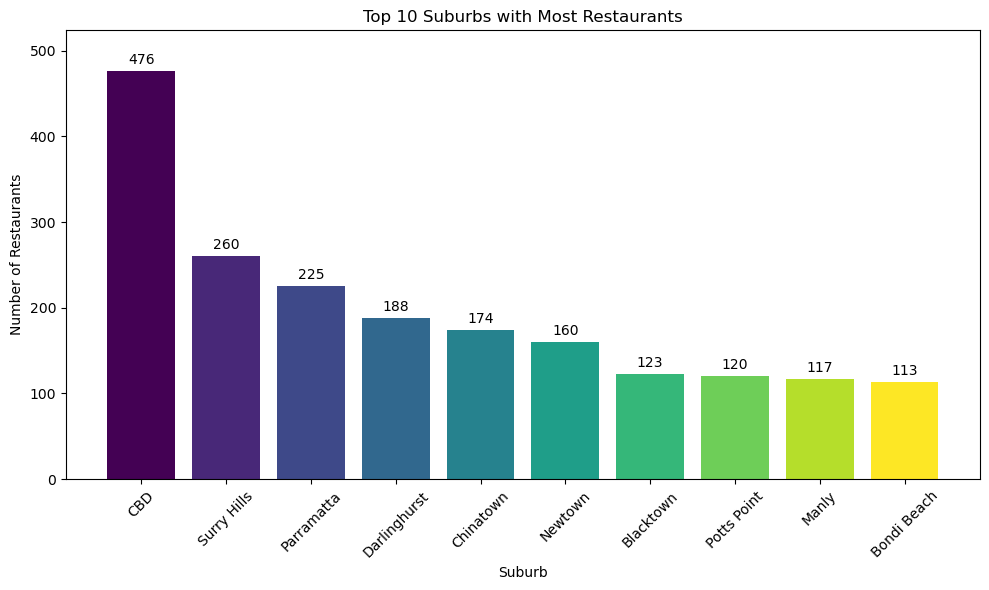

In [9]:
top10 = df['subzone'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(10, 6))
colors = mpl.colormaps["viridis"](np.linspace(0, 1, len(top10)))
bars = ax.bar(top10.index, top10.values, color=colors)

ax.set_ylim(0, top10.values.max() * 1.10) # leave some headroom for labels
ax.bar_label(bars, padding=3) # add labels
ax.set_title("Top 10 Suburbs with Most Restaurants")
ax.set_xlabel("Suburb")
ax.set_ylabel("Number of Restaurants")
ax.tick_params(axis="x", rotation=45)
fig.tight_layout()
plt.show()

#### Part A.2.3. Are restaurants with "Excellent" ratings more expensive than those with "Poor" ratings? Support with visuals (histograms or stacked bars)

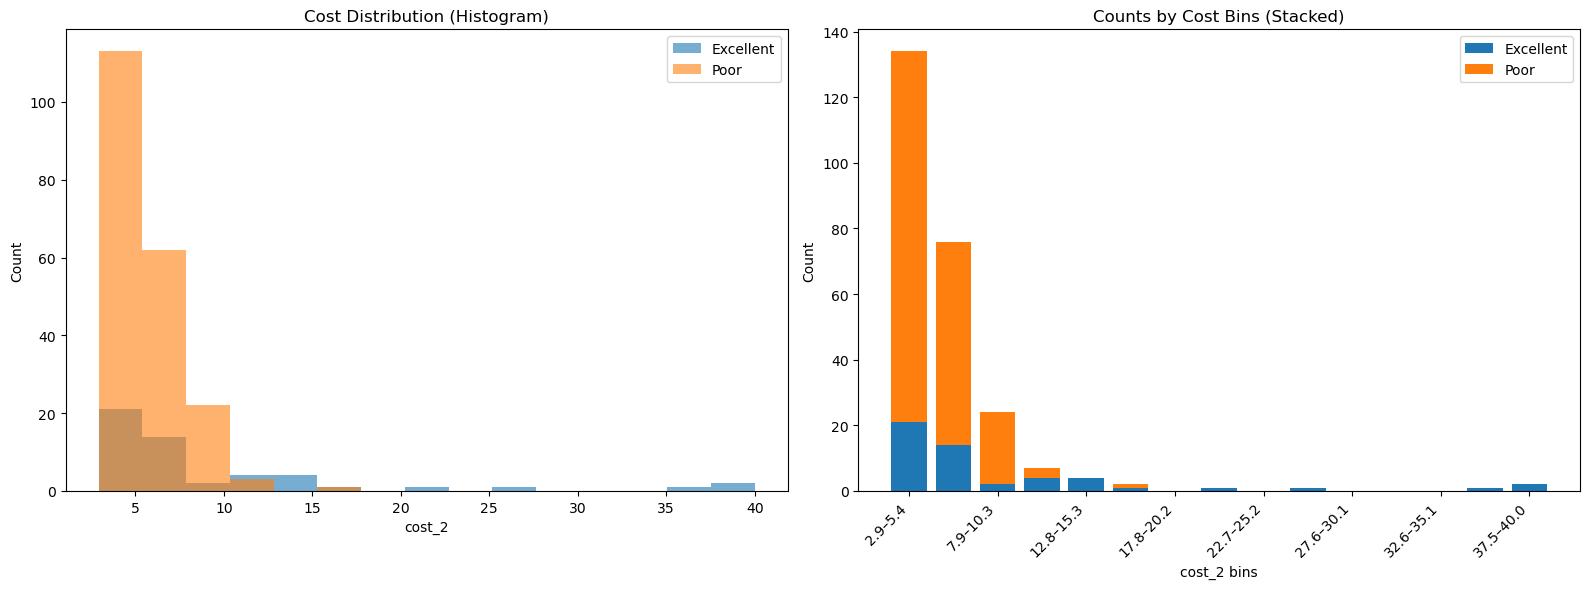

Mean  — Excellent: 9.23  | Poor: 5.7
Median— Excellent: 6.02  | Poor: 5.24


In [10]:
# Two groups (assumes numeric 'cost_2' exists)
ex = df.loc[df["rating_text"] == "Excellent", "cost_2"].dropna().to_numpy()
po = df.loc[df["rating_text"] == "Poor", "cost_2"].dropna().to_numpy()

# Shared bins for fair comparison
bins = np.histogram_bin_edges(np.r_[ex, po], bins=15)

# Stacked-bar prep
exc_counts, _  = np.histogram(ex, bins=bins)
poor_counts, _ = np.histogram(po, bins=bins)
x = np.arange(len(bins) - 1)
bin_labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(len(bins)-1)]

# 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: overlaid histograms
axes[0].hist(ex, bins=bins, alpha=0.6, label="Excellent")
axes[0].hist(po, bins=bins, alpha=0.6, label="Poor")
axes[0].set_title("Cost Distribution (Histogram)")
axes[0].set_xlabel("cost_2")
axes[0].set_ylabel("Count")
axes[0].legend()

# Right: stacked bars
axes[1].bar(x, exc_counts, label="Excellent")
axes[1].bar(x, poor_counts, bottom=exc_counts, label="Poor")
axes[1].set_title("Counts by Cost Bins (Stacked)")
axes[1].set_xlabel("cost_2 bins")
axes[1].set_ylabel("Count")
axes[1].set_xticks(x[::2])
axes[1].set_xticklabels(bin_labels[::2], rotation=45, ha="right")
axes[1].legend()
fig.tight_layout()
plt.show()

print("Mean  — Excellent:", np.round(ex.mean(), 2), " | Poor:", np.round(po.mean(), 2))
print("Median— Excellent:", np.round(np.median(ex), 2), " | Poor:", np.round(np.median(po), 2))

<div class="callout note">
  <p><strong>Part A.3. Explore key variables</strong></p>
<p>
<strong>Part A.3.1. Distribution of cost, ratings, and restaurant types</strong>

Using histogram for `cost_2` (a scaled version of `cost`) and `rating_number` of which both are numeric. For `rating_text` and `type`, bar plot is deployed as they are categorical.
</p>
<p>
<strong>Part A.3.2. Correlation between cost and votes</strong>
</p>
The correlation between cost and votes is about 0.27. Since `cost_2` is just a scaled transformation of cost, its correlation with votes is identical (0.27). The correlation coefficient between cost and votes is 0.27, which can be interpreted as a weak positive relationship. The scatter plot likewise shows only a faint upward trend with no clear pattern which is consistent with a weak positive association.
</p>
<p>
<strong>Part A.3.3. Any interesting trends you observe</strong>

Note, `cost_2` is a scaled transformation of cost. In this study, `cost_2` is used for analysis/plots as there is no specific need for the original price values from cost. The histogram for `cost_2` shows that the distribution is right-skewed indicating majority of the restaurant spending clustered at lower cost. The histogram for `rating_number` shows almost a perfect symmetrically normal distribution indicating patrons rate restaurant visits between 3.0-3.5 which is reflected in the `rating_text` histogram where 'average' and 'good' are common. Finally, from the restaurant `type`, casual dining and cafe are the most common amongst all.

In addition, the correlation matrix indicates that `cost` and `cost_2` are perfectly correlated (1.000), making them redundant versions of the same variable. Each shows only a weak positive correlation with `rating_number` (0.231) and `votes` (0.270), implying that price is only loosely related to ratings and vote counts. By contrast, `rating_number` and `votes` display a moderately strong positive association (0.535), suggesting that higher ratings tend to coincide with more votes (and potentially the reverse).
</p>
</div>

### <font color='navy'>Part A.3. Explore key variables</font>

#### Part A.3.1. Distribution of cost, ratings, and restaurant types

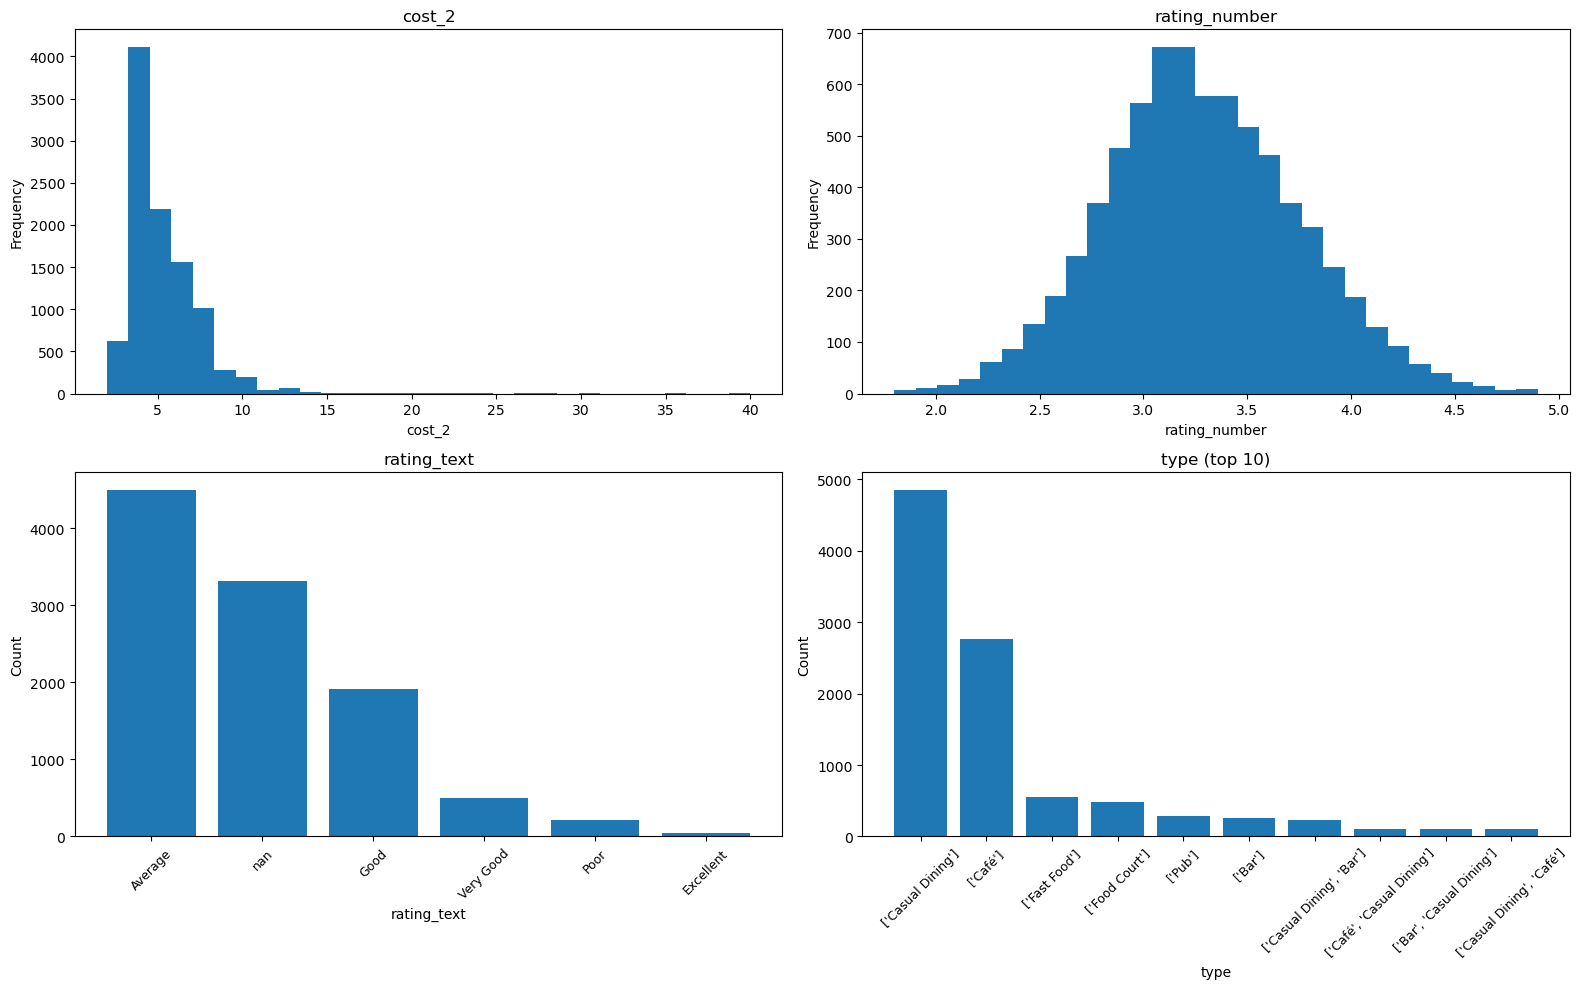


Skewness (cost_2, rating_number)
--------------------------------
cost_2                3.253
rating_number         0.162
--------------------------------


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1) cost_2 (numeric)
axes[0, 0].hist(df["cost_2"].dropna(), bins=30)
axes[0, 0].set_title("cost_2")
axes[0, 0].set_xlabel("cost_2")
axes[0, 0].set_ylabel("Frequency")

# 2) rating_number (numeric)
axes[0, 1].hist(df["rating_number"].dropna(), bins=30)
axes[0, 1].set_title("rating_number")
axes[0, 1].set_xlabel("rating_number")
axes[0, 1].set_ylabel("Frequency")

# 3) rating_text (categorical → counts)
rt = df["rating_text"].astype(str).value_counts()
axes[1, 0].bar(rt.index, rt.values)
axes[1, 0].set_title("rating_text")
axes[1, 0].set_xlabel("rating_text")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis="x", rotation=45, labelsize=9)

# 4) type (categorical → counts; show top 10 for readability)
tp = df["type"].astype(str).value_counts().head(10)
axes[1, 1].bar(tp.index, tp.values)
axes[1, 1].set_title("type (top 10)")
axes[1, 1].set_xlabel("type")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis="x", rotation=45, labelsize=9)

plt.tight_layout()
plt.show()

title = "Skewness (cost_2, rating_number)"
print(f"\n{title}\n{'-'*len(title)}")
print(f"{'cost_2':<18} {df['cost_2'].skew():>8.3f}")
print(f"{'rating_number':<18} {df['rating_number'].skew():>8.3f}")
print(f"{'-'*len(title)}")

#### Part A.3.2. Correlation between cost and votes


Correlation with votes (cost, cost_2, rating_number)
----------------------------------------------------
                cost  cost_2  rating_number  votes
cost           1.000   1.000          0.231  0.270
cost_2         1.000   1.000          0.231  0.270
rating_number  0.231   0.231          1.000  0.535
votes          0.270   0.270          0.535  1.000
----------------------------------------------------


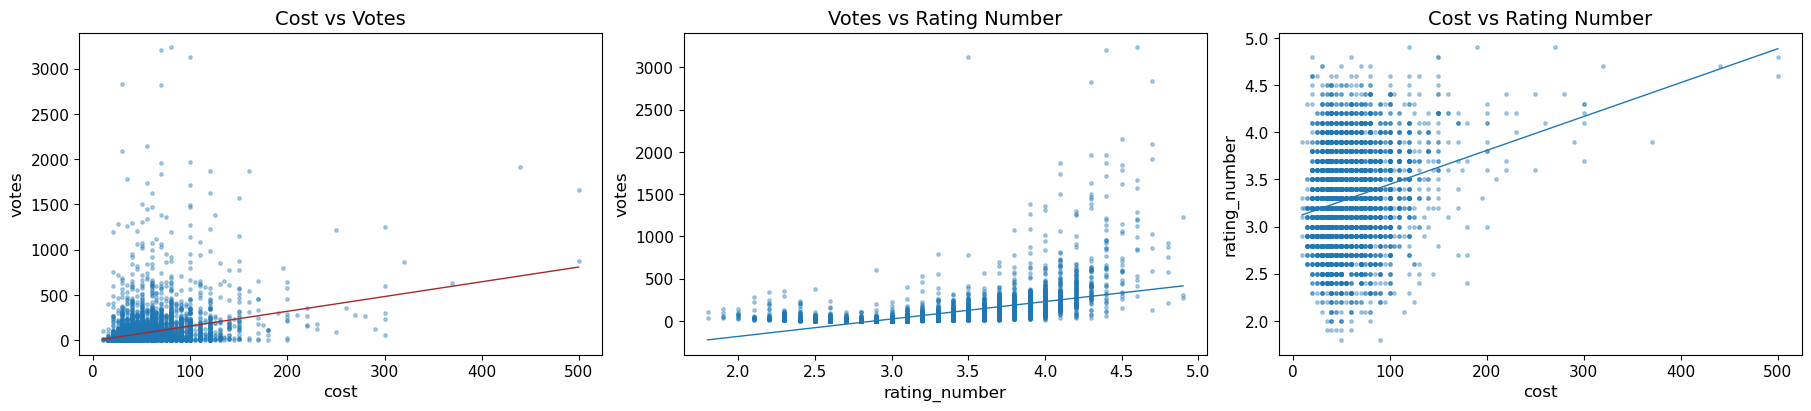

In [12]:
title = "Correlation with votes (cost, cost_2, rating_number)"
print(f"\n{title}\n{'-'*len(title)}")
num_cols = ["cost", "cost_2", "rating_number", "votes"]
corr = df[num_cols].corr().round(3)
print(corr)
print(f"{'-'*len(title)}")

TITLE_FONTSIZE = 14
LABEL_FONTSIZE = 12
TICK_FONTSIZE  = 11

z1 = df[["cost","votes"]].dropna()
x1, y1 = z1["cost"].to_numpy(), z1["votes"].to_numpy()

z2 = df[["rating_number","votes"]].dropna()
x2, y2 = z2["rating_number"].to_numpy(), z2["votes"].to_numpy()

z3 = df[["cost","rating_number"]].dropna()
x3, y3 = z3["cost"].to_numpy(), z3["rating_number"].to_numpy()

# --- Plots ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)

# Left: cost vs votes (brown line)
ax1.scatter(x1, y1, s=6, alpha=0.35)
if x1.size >= 2 and np.nanstd(x1) > 0:
    m1, b1 = np.polyfit(x1, y1, 1)
    xs1 = np.linspace(x1.min(), x1.max(), 200)
    ax1.plot(xs1, m1*xs1 + b1, linewidth=1, color="brown")
ax1.set_xlabel("cost", fontsize=LABEL_FONTSIZE)
ax1.set_ylabel("votes", fontsize=LABEL_FONTSIZE)
ax1.set_title("Cost vs Votes", fontsize=TITLE_FONTSIZE)
ax1.tick_params(axis="both", labelsize=TICK_FONTSIZE)

# Middle: rating_number vs votes
ax2.scatter(x2, y2, s=6, alpha=0.35)
if x2.size >= 2 and np.nanstd(x2) > 0:
    m2, b2 = np.polyfit(x2, y2, 1)
    xs2 = np.linspace(x2.min(), x2.max(), 200)
    ax2.plot(xs2, m2*xs2 + b2, linewidth=1)
ax2.set_xlabel("rating_number", fontsize=LABEL_FONTSIZE)
ax2.set_ylabel("votes", fontsize=LABEL_FONTSIZE)
ax2.set_title("Votes vs Rating Number", fontsize=TITLE_FONTSIZE)
ax2.tick_params(axis="both", labelsize=TICK_FONTSIZE)

# Right: cost vs rating_number
ax3.scatter(x3, y3, s=6, alpha=0.35)
if x3.size >= 2 and np.nanstd(x3) > 0:
    m3, b3 = np.polyfit(x3, y3, 1)
    xs3 = np.linspace(x3.min(), x3.max(), 200)
    ax3.plot(xs3, m3*xs3 + b3, linewidth=1)
ax3.set_xlabel("cost", fontsize=LABEL_FONTSIZE)
ax3.set_ylabel("rating_number", fontsize=LABEL_FONTSIZE)
ax3.set_title("Cost vs Rating Number", fontsize=TITLE_FONTSIZE)
ax3.tick_params(axis="both", labelsize=TICK_FONTSIZE)

plt.show()

#### Part A.3.3. Any interesting trends you observe

In [13]:
# See answers above

<div class="callout note">
  <p><strong>Part A.4. Geospatial Analysis</strong></p>
<p>
<strong>Part A.4.1. Use sydney.geojson (attached) and geopandas library to show cuisine density per suburb</strong>
</p>
<p>
<strong>Part A.4.2. Colour each suburb by the number of restaurants serving a given cuisine</strong>
</p>
</div>

### <font color='navy'>Part A.4. Geospatial Analysis</font>

#### Part A.4.1. Use sydney.geojson (attached) and geopandas library to show cuisine density per suburb

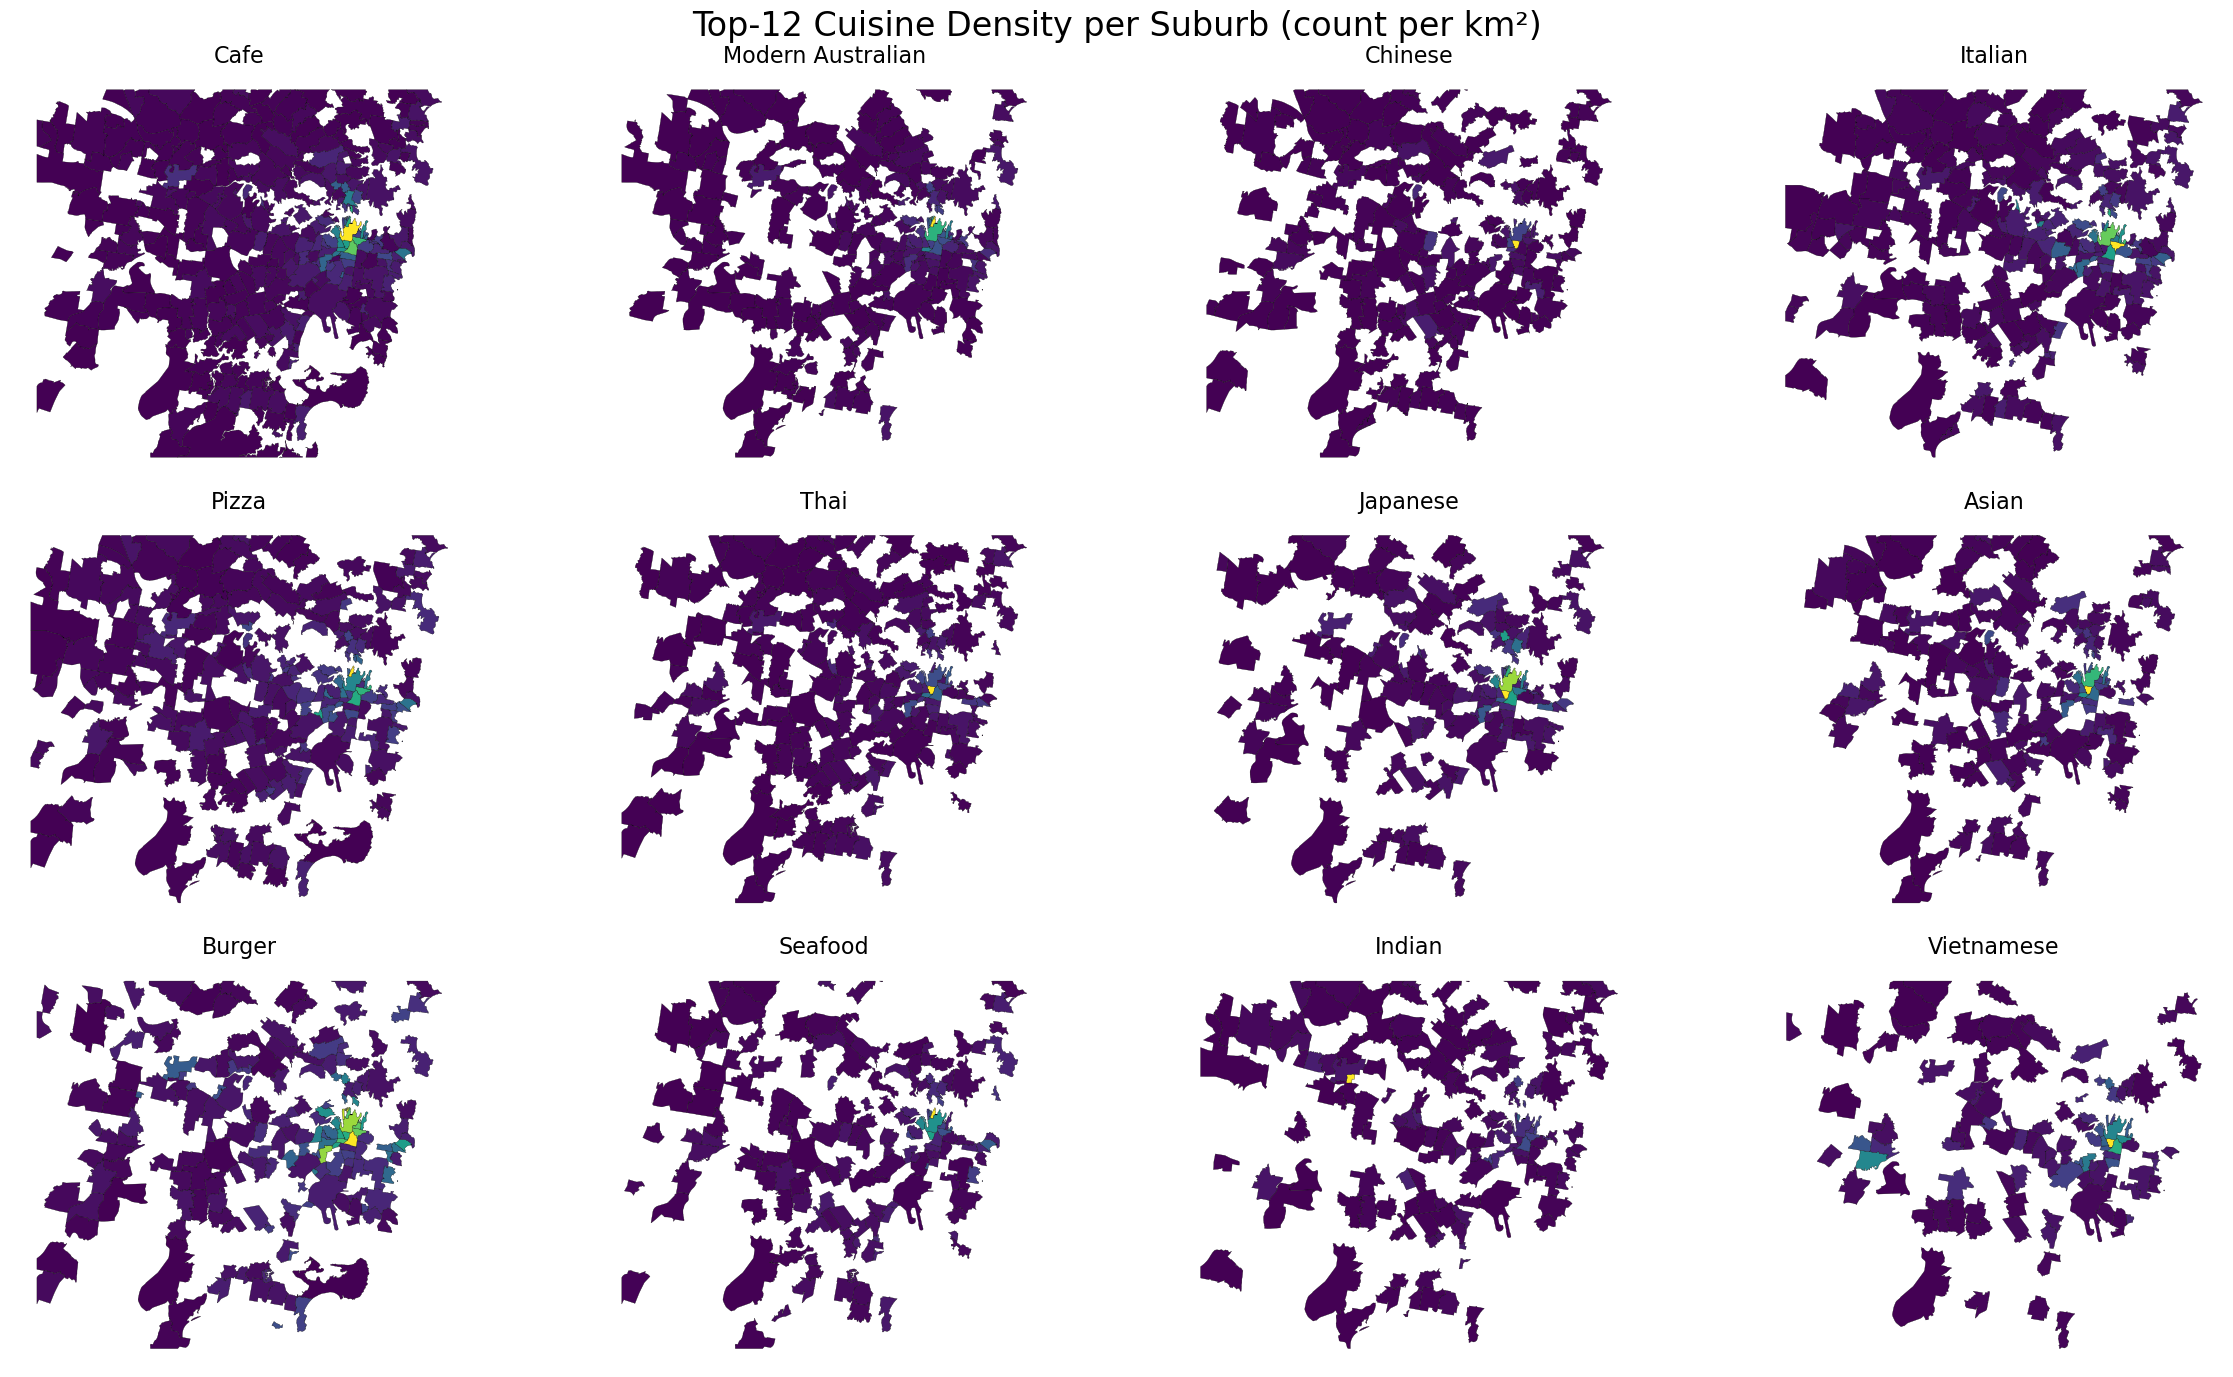

In [14]:
# Minimal GeoPandas: Top-10 cuisine density per suburb (2×5)

os.environ["PROJ_LIB"] = pyproj.datadir.get_data_dir()

# --- Config (edit if your column names differ) ---
# Papermill will inject DATA_CSV; fall back to relative path for interactive runs
try:
    DATA_CSV
except NameError:
    DATA_CSV = "data/zomato_df_final_data.csv"
BASE = str(DATA_CSV.parent) + "/"  # "data/"

GEOJSON_PATH = BASE + "sydney.geojson"
CSV_PATH     = BASE + "zomato_df_final_data.csv"

# Infer column names once
_cols = pd.read_csv(CSV_PATH, nrows=1).columns
LAT_COL     = [c for c in _cols if "lat" in c.lower()][0]
LON_COL     = [c for c in _cols if ("lon" in c.lower()) or ("lng" in c.lower()) or ("long" in c.lower())][0]
CUISINE_COL = [c for c in _cols if "cuisine" in c.lower()][0]

# --- Suburbs + area (km²) ---
gdf_sub = gpd.read_file(GEOJSON_PATH)
gdf_sub = gdf_sub[gdf_sub.geometry.notna()].copy()
name_col = [c for c in gdf_sub.columns if str(c).lower() in ("name","suburb","suburb_name","lga_name","sa2_name","ssc_name")]
name_col = name_col[0] if name_col else gdf_sub.columns[0]
gdf_area = gdf_sub.to_crs(3857)
gdf_sub["area_km2"] = gdf_area.geometry.area / 1_000_000

# --- Restaurants as points ---
df = pd.read_csv(CSV_PATH, usecols=[LAT_COL, LON_COL, CUISINE_COL]).dropna()
gdf_pts = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[LON_COL], df[LAT_COL]), crs=4326)

# --- Spatial join (points → suburbs) ---
gdf_join = gpd.sjoin(gdf_pts, gdf_sub.to_crs(4326), how="inner", predicate="within")

# --- Explode cuisines and densities ---
def split_cuisines(s):
    s = str(s).replace("/", ",").replace("[","").replace("]","")
    return [p.strip().strip("'").strip('"') for p in s.split(",") if p.strip()]

gdf_join["cuisine"] = gdf_join[CUISINE_COL].apply(split_cuisines)
gdf_c = gdf_join.explode("cuisine").dropna(subset=["cuisine"])
c_counts = (
    gdf_c.groupby([name_col, "cuisine"]).size().to_frame("count").reset_index()
    .merge(gdf_sub[[name_col, "area_km2"]], on=name_col, how="left")
)
c_counts["density_per_km2"] = c_counts["count"] / c_counts["area_km2"]

# Bigger titles for 4×3 grid
TITLE_SIZE = 16
SUP_TITLE_SIZE = 24

top12 = (
    c_counts.groupby("cuisine")["count"].sum()
    .sort_values(ascending=False).head(12).index.tolist()
)

fig, axes = plt.subplots(3, 4, figsize=(24, 14))
axes = axes.ravel()
for ax, cuisine in zip(axes, top12):
    sub = c_counts[c_counts["cuisine"] == cuisine][[name_col, "density_per_km2"]]
    plot_df = gdf_sub.merge(sub, on=name_col, how="left")
    plot_df.plot(column="density_per_km2", ax=ax, legend=False, edgecolor="black", linewidth=0.2)
    ax.set_title(cuisine, fontsize=TITLE_SIZE)
    ax.set_axis_off()

for ax in axes[len(top12):]:
    ax.set_visible(False)

fig.suptitle("Top-12 Cuisine Density per Suburb (count per km²)", fontsize=SUP_TITLE_SIZE)
plt.tight_layout()
plt.show()

#### Part A.4.2. Colour each suburb by the number of restaurants serving a given cuisine

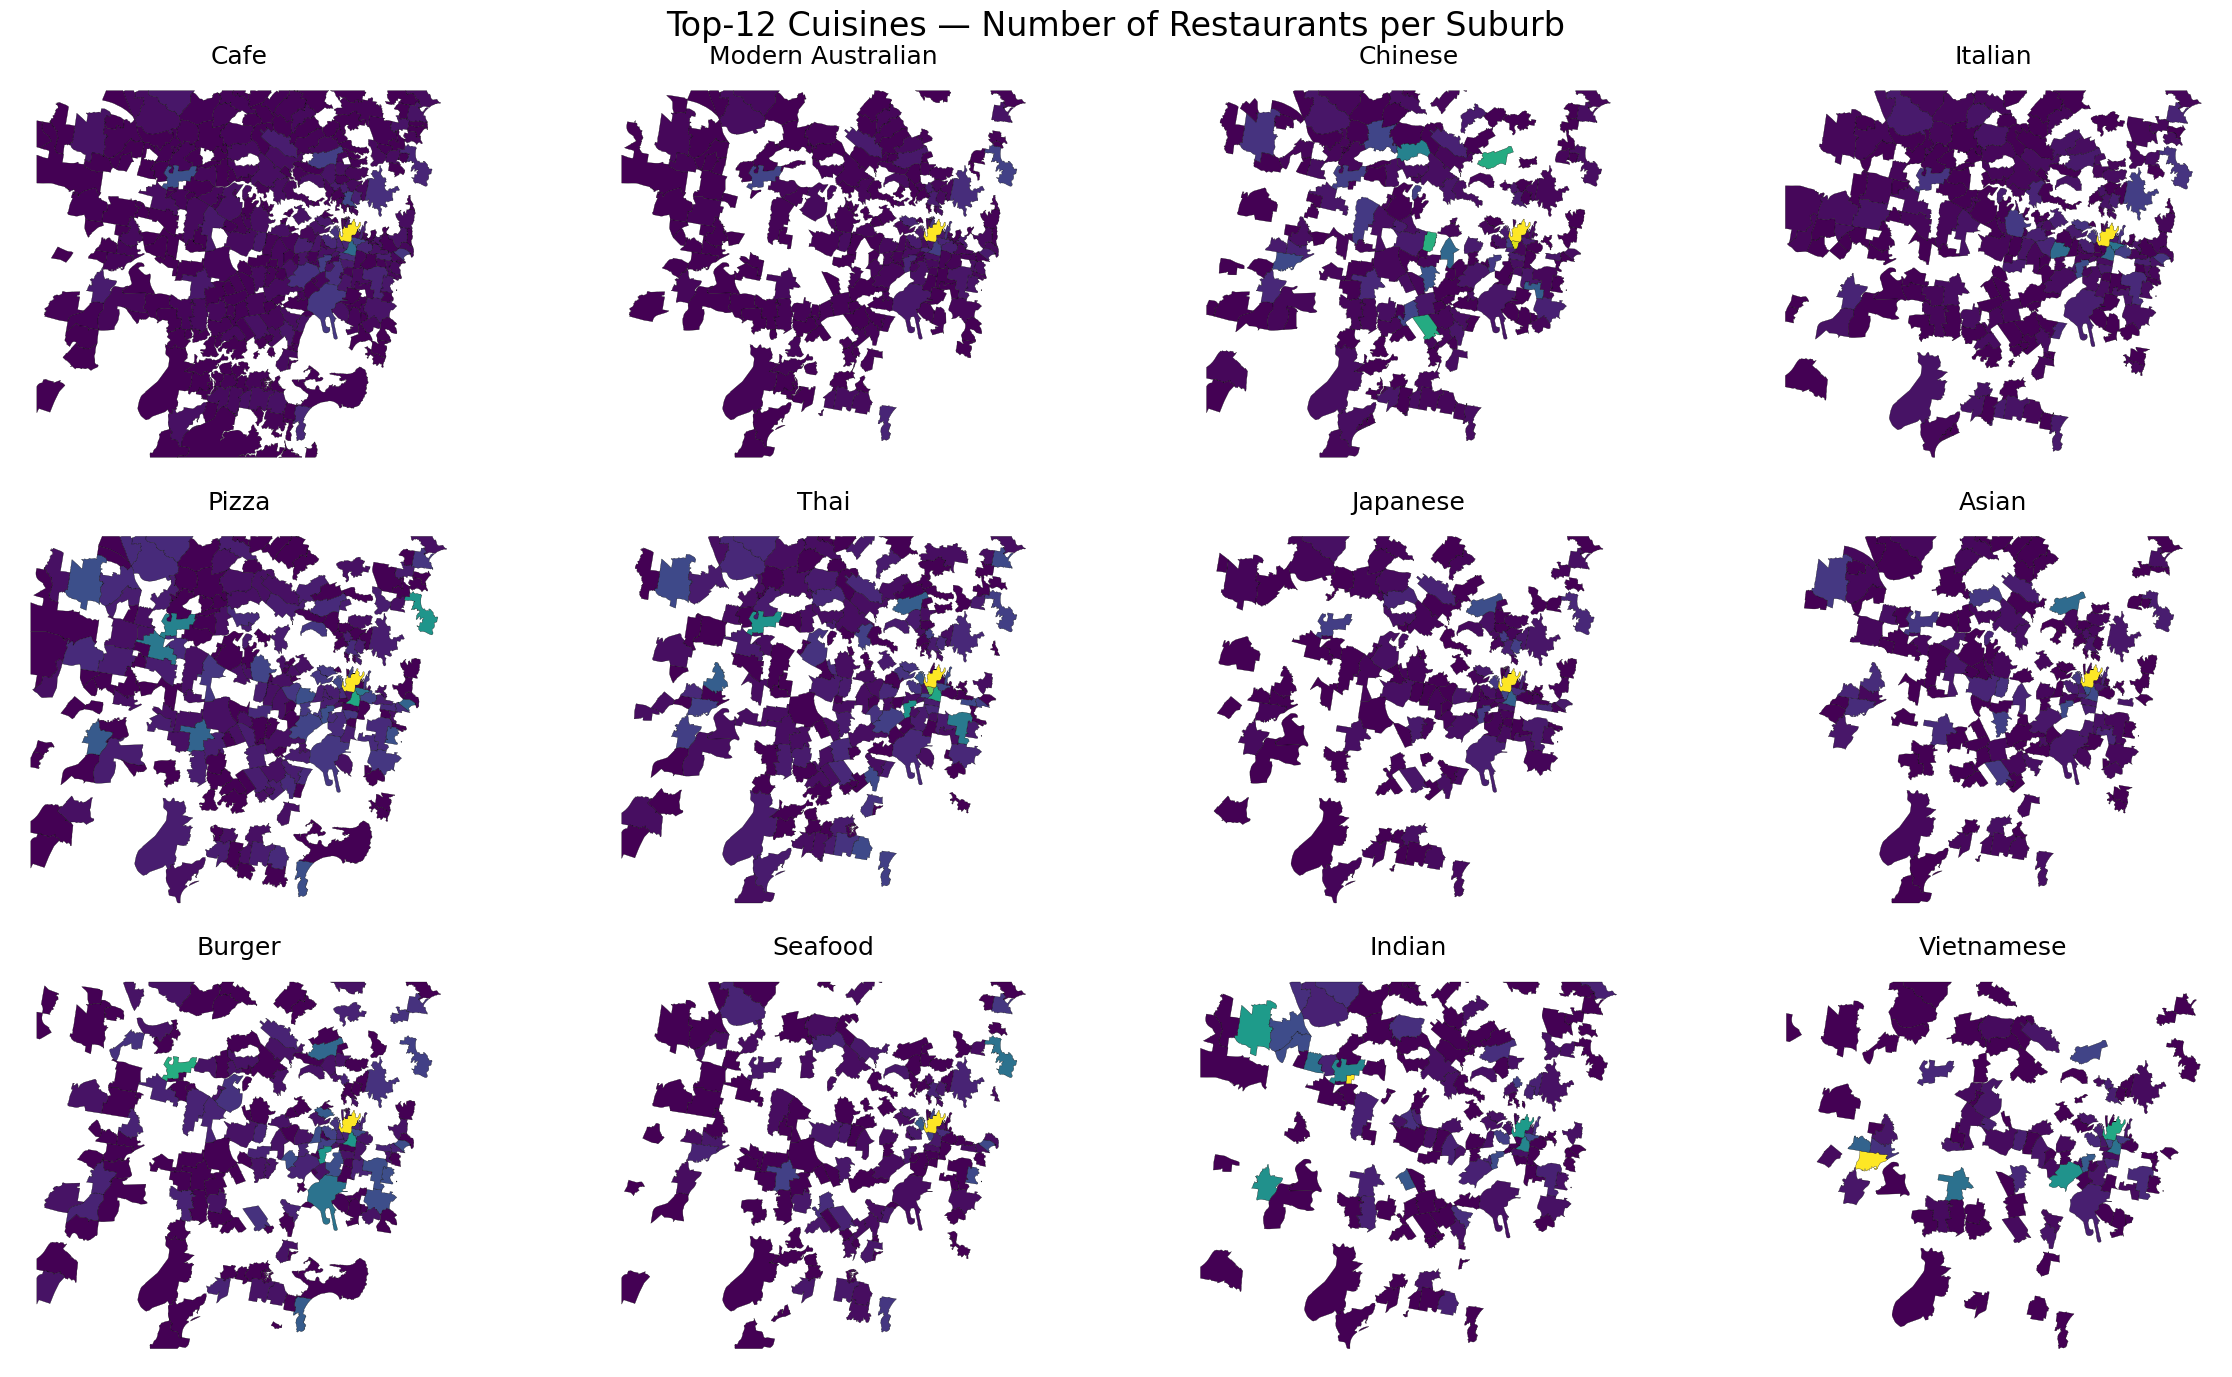

In [15]:
TITLE_SIZE = 18      # per-panel title size
SUP_TITLE_SIZE = 24  # overall title size

# pick top 12 cuisines by total count
top12 = (
    c_counts.groupby("cuisine")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(12)
    .index.tolist()
)

fig, axes = plt.subplots(3, 4, figsize=(24, 14))
axes = axes.ravel()

for ax, cuisine in zip(axes, top12):
    sub_counts = (
        c_counts[c_counts["cuisine"] == cuisine][[name_col, "count"]]
        .rename(columns={"count": "restaurants_serving_cuisine"})
    )
    plot_df = gdf_sub.merge(sub_counts, on=name_col, how="left")
    plot_df.plot(
        column="restaurants_serving_cuisine",
        ax=ax,
        legend=False,
        edgecolor="black",
        linewidth=0.2,
    )
    ax.set_title(cuisine, fontsize=TITLE_SIZE)
    ax.set_axis_off()

# hide any leftover axes if there are fewer than 12 cuisines
for ax in axes[len(top12):]:
    ax.set_visible(False)

fig.suptitle("Top-12 Cuisines — Number of Restaurants per Suburb", fontsize=SUP_TITLE_SIZE)
plt.tight_layout()
plt.show()

<div class="callout note">
  <p><strong>Part A.5. Interactive Visualisation</strong></p>
<p>
<strong>Part A.5.1. Choose one insight where static plots are limiting</strong>
</p>
<p>
<strong>Part A.5.2. Recreate it using Plotly or Bokeh and explain why the interactive version is better</strong>
</p>
</div>

### <font color='navy'>Part A.5. Interactive Visualisation</font>

#### Part A.5.1. Choose one insight where static plots are limiting

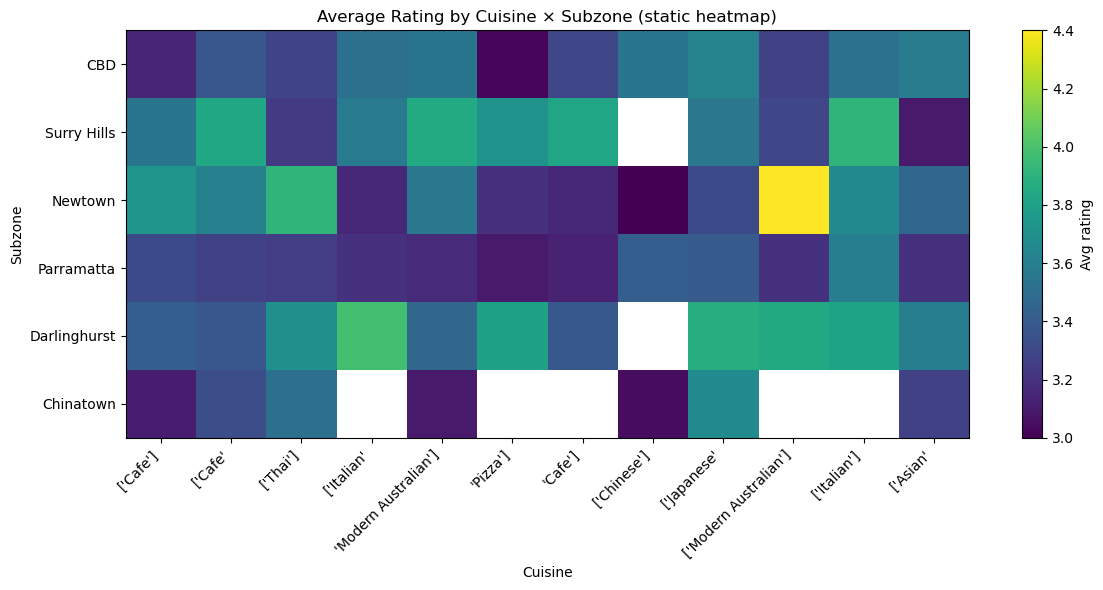

In [16]:
# Papermill will inject DATA_CSV; fall back to relative path for interactive runs
try:
    DATA_CSV
except NameError:
    DATA_CSV = "data/zomato_df_final_data.csv"

DATA_CSV = Path(DATA_CSV)
df = pd.read_csv(DATA_CSV)

# Prep
df["rating"] = pd.to_numeric(df["rating_number"], errors="coerce")
cost = pd.to_numeric(df["cost"], errors="coerce")
bins = pd.qcut(cost, 4, duplicates="drop")
df["price_band"] = pd.factorize(bins, sort=True)[0] + 1

df = df.assign(cuisine=df["cuisine"].astype(str).str.split(",")).explode("cuisine", ignore_index=True)
df["cuisine"] = df["cuisine"].astype(str).str.strip().str.title()
df = df.dropna(subset=["rating","cuisine","price_band","subzone"])
df = df[df["cuisine"] != ""]

# Scope for readability
top_cuis  = df["cuisine"].value_counts().head(12).index.tolist()
top_zones = df["subzone"].value_counts().head(6).index.tolist()
scoped = df[df["cuisine"].isin(top_cuis) & df["subzone"].isin(top_zones)]

# Aggregate
mean_tbl = (scoped.groupby(["subzone","cuisine"])["rating"].mean()
            .unstack("cuisine").reindex(index=top_zones, columns=top_cuis))

# Static heatmap (good snapshot, but no counts/filters)
plt.figure(figsize=(12,6))
plt.imshow(mean_tbl.to_numpy(), aspect="auto")
plt.colorbar(label="Avg rating")
plt.yticks(range(len(mean_tbl.index)), mean_tbl.index)
plt.xticks(range(len(mean_tbl.columns)), mean_tbl.columns, rotation=45, ha="right")
plt.title("Average Rating by Cuisine × Subzone (static heatmap)")
plt.xlabel("Cuisine"); plt.ylabel("Subzone")
plt.tight_layout(); plt.show()

#### Part A.5.2. Recreate it using Plotly or Bokeh and explain why the interactive version is better

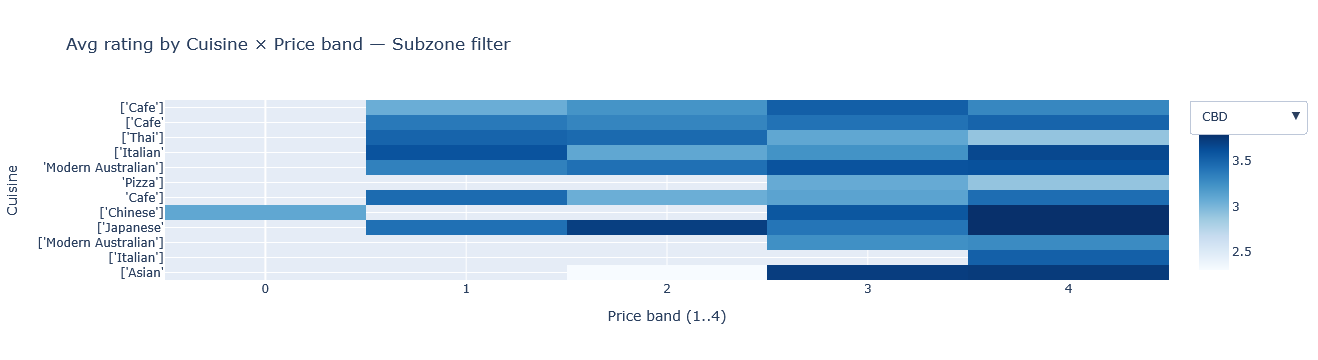

In [17]:
# Plotly: Using interactive heatmap with Subzone dropdown + hover counts

df["rating"] = pd.to_numeric(df["rating_number"], errors="coerce")
cost = pd.to_numeric(df["cost"], errors="coerce")
bins = pd.qcut(cost, 4, duplicates="drop")
df["price_band"] = pd.factorize(bins, sort=True)[0] + 1

df = df.assign(cuisine=df["cuisine"].astype(str).str.split(",")).explode("cuisine", ignore_index=True)
df["cuisine"] = df["cuisine"].astype(str).str.strip().str.title()
df = df.dropna(subset=["rating","cuisine","price_band","subzone"])
df = df[df["cuisine"] != ""]

top_cuis  = df["cuisine"].value_counts().head(12).index.tolist()
top_zones = df["subzone"].value_counts().head(6).index.tolist()

agg = (df[df["cuisine"].isin(top_cuis) & df["subzone"].isin(top_zones)]
       .groupby(["subzone","cuisine","price_band"])
       .agg(mean=("rating","mean"), n=("rating","size")).reset_index())
bands = sorted(agg["price_band"].unique())

def mats(zone):
    a = agg[agg["subzone"]==zone]
    z  = (a.pivot(index="cuisine", columns="price_band", values="mean")
            .reindex(index=top_cuis, columns=bands))
    cd = (a.pivot(index="cuisine", columns="price_band", values="n")
            .reindex(index=top_cuis, columns=bands))
    return z, cd

init = top_zones[0]
z0, cd0 = mats(init)

fig = px.imshow(z0, aspect="auto", origin="upper", color_continuous_scale="Blues",
                labels=dict(color="Avg rating"),
                title="Avg rating by Cuisine × Price band — Subzone filter")
fig.update_traces(customdata=cd0.to_numpy(),
                  hovertemplate="Cuisine=%{y}<br>Band=%{x}<br>Avg=%{z:.2f}<br>n=%{customdata}<extra></extra>")
fig.update_layout(xaxis_title="Price band (1..4)", yaxis_title="Cuisine")

fig.update_layout(updatemenus=[dict(
    buttons=[dict(label=z,
                  method="update",
                  args=[{"z":[mats(z)[0].to_numpy()],
                         "customdata":[mats(z)[1].to_numpy()]}]) for z in top_zones],
    x=1.02, xanchor="left", y=1.0, yanchor="top"
)])
fig.show()


# Part B – Predictive Modelling

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report, ConfusionMatrixDisplay
                            )

<div class="callout note">
  <p><strong>Part B.1. Feature Engineering</strong></p>
<p>
<strong>Part B.1.1. Handle missing/invalid data (drop or impute). Please justify your choices</strong>
    
The cleaning logic in this code follows a simple but consistent set of principles. 
<ul>
  <li>First, any columns with more than 60% missing values are dropped, because such fields would otherwise require fabricating too much data and would contribute little reliable signal.</li>
  <li>In addition to these imputation rules, rows where both latitude and longitude are missing are dropped entirely because geo-location cannot be reasonably reconstructed when both coordinates are absent.</li>
</ul>
</p>
    
<p>
<strong>Part B.1.2. Encode categorical features properly (Label Encoding, One-Hot, etc.)</strong>
<ul>
  <li>For the remaining numeric columns, missing entries are imputed with the <code>SimpleImputer(strategy="median")</code>, which is robust to skew and outliers which is a common feature of variables like costs, votes, or ratings so the fill-in values are representative without being overly influenced by extremes.</li>
  <li>Categorical and boolean variables are imputed using the most frequent value, <code>SimpleImputer(strategy="most_frequent")</code>, a choice that preserves the prevailing category and makes the fewest assumptions about what the missing entries should be.</li>
  <li>Note, that there is no need of <code>OrdinalEncoder()</code> as there is no ordinal feature.</li>
  <li>Exclude <em>rating_text</em> from being one-hot-encoded as it will be used as the target in classification exercise.</li>
  <li>Segregate targets; <em>rating_number</em> and <em>rating_text</em> from the original DataFrame to prevent learning from imputed values.</li>
  <li><code>ColumnTransformer</code> is used solely to prepare the data in a structured and reproducible way which specifies transformations by feature type (passing through numeric and boolean variables, while one-hot encoding categorical variables with <code>handle_unknown="ignore"</code>, applies them in a single, consistent step. Note that whilst the ColumnTransformer is capable of being integrated into model fitting and inference workflows, it is only used in this study solely for data preparation.</li>
  <li>Note, that after one-hot encoding, the total rows increases tremendously; the original shape is (10500, 17) and after one-hot encoding is (11547, 28662). This is a sparse matrix.</li>
</ul>
</p>

<p>
<strong>Part B.1.3. Create useful features (e.g., cuisine diversity, cost bins)</strong>
</p>
</div>

### <font color='navy'>Part B.1. Feature Engineering</font>

#### Part B.1.1. Handle missing/invalid data (drop or impute). Please justify your choices

In [19]:
# Part B.1.1.

# --- drop very-high-missing columns (> 60%) ---
miss = df.isna().mean()
to_drop = miss[miss > 0.6].index.tolist() # drop columns if >60% missing
df = df.drop(columns=to_drop)

# --- drop rows with both lat & lng missing (if both cols exist) ---
if {"lat", "lng"}.issubset(df.columns):
    both_missing = df["lat"].isna() & df["lng"].isna()
    df = df.loc[~both_missing].reset_index(drop=True)

#### Part B.1.2. Encode categorical features properly (Label Encoding, One-Hot, etc.)

In [20]:
# Part B.1.2.

# --- scikit-learn imputations only ---
df_clean = df.copy()

num_cols   = df_clean.select_dtypes(include=["number"]).columns.tolist()
other_cols = [c for c in df_clean.columns if c not in num_cols]

if num_cols:
    df_clean[num_cols] = SimpleImputer(strategy="median").fit_transform(df_clean[num_cols])
if other_cols:
    df_clean[other_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df_clean[other_cols])

# Segregate targets from the original DataFrame to prevent learning from imputed values
y_reg = df["rating_number"] if "rating_number" in df.columns else pd.Series(index=df.index, dtype="float64")  # for regression
y_clf = df["rating_text"]   if "rating_text"   in df.columns else pd.Series(index=df.index, dtype="object")   # for classification

# Features: drop both targets; one for regression, 'rating_number' and the other, classification, 'rating_text'
X = df_clean.drop(columns=["rating_text", "rating_number"], errors="ignore")

# Group columns by data type; Boolean, Numeric and Categorical
bool_cols = X.select_dtypes(include=["bool", "boolean"]).columns.tolist()
num_cols  = X.select_dtypes(include=["number"]).columns.difference(bool_cols).tolist()
cat_cols  = X.select_dtypes(include=["object", "string"]).columns.tolist()

ct = ColumnTransformer(
    transformers=[
        ("num",  "passthrough", num_cols),
        ("bool", "passthrough", bool_cols),
        ("ohe",  OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Fit using column transformer
X_enc = ct.fit_transform(X)
feature_names = ct.get_feature_names_out()
X_encoded_df = pd.DataFrame(X_enc, columns=feature_names, index=X.index)
print(f"Total (row, column): {X_encoded_df.shape}")

Total (row, column): (11547, 28662)


#### Part B.1.3. Create useful features (e.g., cuisine diversity, cost bins)

cuisine_diversity → counts the number of distinct cuisines listed for each restaurant (e.g., "Thai, Chinese, Thai" → 2).

cost_bin → categorizes restaurant cost into four price tiers (\\$, \\$\\$, \\$\\$\\$, \\$\\$\\$\\$) based on quartiles (with a simple fallback if not enough unique values).

In [21]:
# Part B.1.3.

df_fe = df_clean[["cuisine", "cost"]].copy()

# cuisine_diversity = number of distinct cuisines (comma-separated)
if "cuisine" in df_fe.columns:
    cuisines = df_fe["cuisine"].fillna("").astype(str).str.split(",")
    df_fe["cuisine_diversity"] = cuisines.apply(
        lambda xs: len({x.strip().lower() for x in xs if x.strip()})
    ).astype("int64")
else:
    df_fe["cuisine_diversity"] = 0

# cost_bin = quartiles mapped to $, $$, $$$, $$$$ (fallback if not enough uniques)
if "cost" in df_fe.columns:
    try:
        df_fe["cost_bin"] = pd.qcut(df_fe["cost"], 4, labels=["$","$$","$$$","$$$$"])
    except ValueError:
        df_fe["cost_bin"] = pd.cut(df_fe["cost"], [-np.inf, 20, 40, 80, np.inf],
                                   labels=["$","$$","$$$","$$$$"])
else:
    df_fe["cost_bin"] = "$"

<div class="callout note">
  <p><strong>Part B.2. Regression Models</strong></p>
<p>
<strong>Part B.2.1. Model A (Linear Regression): Predict rating_number using Scikit-Learn. Split 80% train / 20% test</strong>

The code filters rows with a non-missing regression target to align <code>X_encoded_df</code> and <code>y_reg</code> (cast to float), then do an 80:20 train/test split (no stratify), fit OLS (LinearRegression), predict on the test set, and report MSE, RMSE, MAE, and R^2 for error and explained variance.
</p>
<p>
<strong>Part B.2.2. Model B (Gradient Descent Regression): Implement linear regression with gradient descent</strong>

This code standardises features (fit scaler on train and then apply to test), train an unregularized SGDRegressor (<code>squared-error loss</code>, <code>inverse-scaling LR</code> with <code>eta0=0.01</code>, <code>power_t=0.25</code>, <code>max_iter=200</code>, <code>tol=1e-4</code>, <code>random_state=42</code>), predict on scaled test data, and report MSE, RMSE, MAE, and R^2.
</p>
<p>
<strong>Part B.2.3. Report Mean Squared Error (MSE) for both</strong>

TOGO???
</p>
</div>

### <font color='navy'>Part B.2. Regression Models</font>

#### Part B.2.1. Model A (Linear Regression): Predict rating_number using Scikit-Learn. Split 80% train / 20% test

In [22]:
# Part B.2.1. - around 4 mins for full run

t = time.perf_counter()

# Align features to non-missing regression target
mask_reg = y_reg.notna()
X_reg = X_encoded_df.loc[mask_reg]
y_reg_clean = y_reg.loc[mask_reg].astype(float)

# During development: take a joint 10% sample using the same indices to speed up training
# Comment it out during final actual run
# ------------------------------------------------------
idx10 = X_reg.sample(frac=0.10, random_state=42).index
X_reg = X_reg.loc[idx10]
y_reg_clean = y_reg_clean.loc[idx10]
# ------------------------------------------------------

# Split train/test 80:20
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg_clean, test_size=0.2, random_state=42)

ols = LinearRegression()
ols.fit(X_train, y_train)
y_pred_ols = ols.predict(X_test)

mse_ols  = mean_squared_error(y_test, y_pred_ols)
rmse_ols = np.sqrt(mse_ols)
mae_ols  = mean_absolute_error(y_test, y_pred_ols)
r2_ols   = r2_score(y_test, y_pred_ols)

duration_sec_linr = time.perf_counter() - t

#### Part B.2.2. Model B (Gradient Descent Regression): Implement linear regression with gradient descent

In [23]:
# Part B.2.2.
    
# Scale (fit on train, apply to test)
scaler = StandardScaler(with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

sgd = SGDRegressor(
    loss="huber",  # robust to outliers; start here
        penalty="l2",  # add stabilization
        alpha=1e-4,  # L2 strength
        learning_rate="constant",
        eta0=1e-3, 
        max_iter=5000, # higher number to make it converge
        tol=1e-4,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        average=True,
        random_state=42
)

sgd.fit(X_train_scaled, y_train)
y_pred_sgd = sgd.predict(X_test_scaled)

mse_sgd  = mean_squared_error(y_test, y_pred_sgd)
rmse_sgd = np.sqrt(mse_sgd)
mae_sgd  = mean_absolute_error(y_test, y_pred_sgd)
r2_sgd   = r2_score(y_test, y_pred_sgd)

#### Part B.2.3. Report Mean Squared Error (MSE) for both

In [24]:
# Part B.2.3.

# Side-by-side regression metrics
summary = pd.DataFrame({
    "Model": ["LinearRegression (OLS)", "SGDRegressor (GD)"],
    "MSE":   [mse_ols, mse_sgd],
    "RMSE":  [rmse_ols, rmse_sgd],
    "MAE":   [mae_ols, mae_sgd],
    "R2":    [r2_ols, r2_sgd],
}).set_index("Model")
title = "Linear/Stochastic Gradient Descent Regression Metrics (Accuracy, Precision, Recall, F1)"
print(f"\n{title}\n{'-'*len(title)}")
print(summary)
print(f"{'-'*len(title)}")


Linear/Stochastic Gradient Descent Regression Metrics (Accuracy, Precision, Recall, F1)
---------------------------------------------------------------------------------------
                             MSE      RMSE       MAE         R2
Model                                                          
LinearRegression (OLS)  0.000281  0.016750  0.010384   0.998652
SGDRegressor (GD)       8.493660  2.914388  2.869200 -39.807874
---------------------------------------------------------------------------------------


<div class="callout note">
  <p><strong>Part B.3. Classification Models</strong></p>
<p>
<strong>Part B.3.1. Simplify rating_text into binary classes</strong>

This code converts <code>rating_text</code> into a binary target (2 for Good/Very Good/Excellent and 1 for Poor/Average whilst preserving missing as <NA>) and prints the class counts to determine the class is balance. The class is mildly imbalanced.
</p>
<p>
<p>
<strong>Part B.3.2. Train Logistic Regression (train/test = 80/20)</strong>

This code filters rows with a non-missing binary classification target to align <code>X_encoded_df</code> and <code>y_clf_bin</code> (cast to int) and then performs an 80:20 stratified split to preserve class balance. It fits Logistic Regression (<code>lbfgs</code>, <code>max_iter=1200</code>), predicts on the test set, and finally saves the trained model to <code>outputs/logr_model.pkl</code> (the directory will be created if it does not exist).
</p>
<p>
<strong>Part B.3.3. Evaluate with confusion matrix, precision, recall, F1</strong>

<code>pos_label=2</code> tells scikit-learn when using average="binary", the positive class is the label 2 ("Good/Very Good/Excellent" group), not the default label 1 ("Poor/Average"). This is crucial as metrics such as precision, recall, and F1 are computed with respect to the positive class. Without setting <code>pos_label=2</code>, scikit-learn would treat "Poor/Average" (class 1) as positive and the metrics would describe the wrong class. However, setting <code>pos_label=2</code> ensures the reported precision/recall/F1 reflect how well the model identifies the "Good/Very Good/Excellent" class.
</p>
<p>
<strong>Part B.3.4. Train 3 more models (e.g., Random Forest, Gradient Boosted Trees, SVM, Neural Net). Compare results in a table</strong>
</p>
</div>

### <font color='navy'>Part B.3. Classification Models</font>

#### Part B.3.1. Simplify rating_text into binary classes: 
 - Class 1: Poor + Average
 - Class 2: Good + Very Good + Excellent

In [25]:
# Part B.3.1.

# Build binary target from rating_text where Classes: 1 = (Poor/Average), 2 = (Good/Very Good/Excellent)
good = {"Good", "Very Good", "Excellent"}
s = y_clf.isin(good).where(y_clf.notna()).astype("boolean")
y_clf_bin = s.map({True: 2, False: 1}).astype("Int64")

# Display the class balance
print(y_clf_bin.value_counts(dropna=False))

rating_text
1    7336
2    4211
Name: count, dtype: Int64


#### Part B.3.2. Train Logistic Regression (train/test = 80/20)

In [26]:
# Part B.3.2.

t = time.perf_counter()
MODEL_OUTPATH = "outputs/logr_model.pkl"

# Align features to non-missing classification target
mask_clf = y_clf_bin.notna()
X_clf = X_encoded_df.loc[mask_clf]
y_clf_clean = y_clf_bin.loc[mask_clf].astype(int)

# Split 80:20 and stratify to preserve class balance
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf_clean, 
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=y_clf_clean)
# Train Logistic Regression
logreg = LogisticRegression(solver="lbfgs", max_iter=1200) # 1200 will converge
logreg.fit(X_train_c, y_train_c)
y_pred_c = logreg.predict(X_test_c)


# Save the logistic regression model to physical location
os.makedirs(os.path.dirname(MODEL_OUTPATH), exist_ok=True)
joblib.dump(logreg, MODEL_OUTPATH)
print(f"Saved model to: {MODEL_OUTPATH}")

duration_sec_logr = time.perf_counter() - t

Saved model to: outputs/logr_model.pkl


#### Part B.3.3. Evaluate with confusion matrix, precision, recall, F1


Logistic Regression Classification Metrics (Accuracy, Precision, Recall, F1)
----------------------------------------------------------------------------
                    Accuracy  Precision(pos=2)  Recall(pos=2)  F1(pos=2)
LogisticRegression       1.0               1.0            1.0        1.0
----------------------------------------------------------------------------


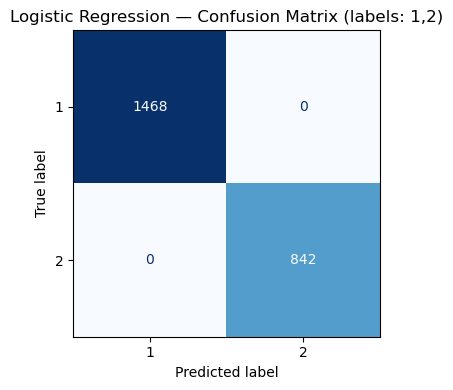

In [27]:
# Part B.3.3.

# Metrics (treat Class 2 as the "positive" class)
acc = accuracy_score(y_test_c, y_pred_c)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test_c, y_pred_c, average="binary", pos_label=2, zero_division=0
)
results = {}
results["LogisticRegression"] = [acc, prec, rec, f1] # store the result for Part B.3.4. later
cm = confusion_matrix(y_test_c, y_pred_c, labels=[1, 2])

# Summary
summary_clf = pd.DataFrame([{
    "Accuracy": acc,
    "Precision(pos=2)": prec,
    "Recall(pos=2)": rec,
    "F1(pos=2)": f1,
}], index=["LogisticRegression"]).round(4)

title = "Logistic Regression Classification Metrics (Accuracy, Precision, Recall, F1)"
print(f"\n{title}\n{'-'*len(title)}")
print(summary_clf)
print(f"{'-'*len(title)}")

# Plot the Confusion Matrix
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2])
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
ax.set_title("Logistic Regression — Confusion Matrix (labels: 1,2)")
plt.tight_layout()
plt.show()

#### Part B.3.4. Train 3 more models (e.g., Random Forest, Gradient Boosted Trees, SVM, Neural Net). Compare results in a table

In [28]:
# Part B.3.4. - around 41 mins for full run
'''    
# 1) Random Forest (no scaling needed)
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_c, y_train_c)
pred = rf.predict(X_test_c)
acc_ = accuracy_score(y_test_c, pred)
prec_, rec_, f1_, _ = precision_recall_fscore_support(y_test_c, pred, average="binary", pos_label=2, zero_division=0)
results["RandomForest"] = [acc_, prec_, rec_, f1_]
print(f"Random Forest - DONE")

# 2) Gradient Boosted Trees (no scaling needed)
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_c, y_train_c)
pred = gb.predict(X_test_c)
acc_ = accuracy_score(y_test_c, pred)
prec_, rec_, f1_, _ = precision_recall_fscore_support(y_test_c, pred, average="binary", pos_label=2, zero_division=0)
results["GradientBoosting"] = [acc_, prec_, rec_, f1_]
print(f"Gradient Boosting - DONE")

# 3) SVM (scaling required)
scaler_cls = StandardScaler(with_mean=True, with_std=True)
X_train_cs = scaler_cls.fit_transform(X_train_c)
X_test_cs  = scaler_cls.transform(X_test_c)

svm = SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)
svm.fit(X_train_cs, y_train_c)
pred = svm.predict(X_test_cs)
acc_ = accuracy_score(y_test_c, pred)
prec_, rec_, f1_, _ = precision_recall_fscore_support(y_test_c, pred, average="binary", pos_label=2, zero_division=0)
results["SVM(RBF)"] = [acc_, prec_, rec_, f1_]
print(f"SVC - DONE")

# 4) Neural Net (MLP) — scale inputs
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu",
                    max_iter=500, early_stopping=True, random_state=42)
mlp.fit(X_train_cs, y_train_c)
pred = mlp.predict(X_test_cs)
acc_ = accuracy_score(y_test_c, pred)
prec_, rec_, f1_, _ = precision_recall_fscore_support(y_test_c, pred, average="binary", pos_label=2, zero_division=0)
results["MLPClassifier"] = [acc_, prec_, rec_, f1_]
print(f"MLP - DONE")

# Summary table
summary_cls = pd.DataFrame.from_dict(
    results, orient="index", columns=["Accuracy", "Precision(pos=2)", "Recall(pos=2)", "F1(pos=2)"]
).round(4)

title = "LR/RD/GBM/SVC/MLP Classification Metrics (Accuracy  Precision(pos=2)  Recall(pos=2)  F1(pos=2))"
print(f"\n{title}\n{'-'*len(title)}")
print(summary_cls)
print(f"{'-'*len(title)}")
'''

'    \n# 1) Random Forest (no scaling needed)\nrf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)\nrf.fit(X_train_c, y_train_c)\npred = rf.predict(X_test_c)\nacc_ = accuracy_score(y_test_c, pred)\nprec_, rec_, f1_, _ = precision_recall_fscore_support(y_test_c, pred, average="binary", pos_label=2, zero_division=0)\nresults["RandomForest"] = [acc_, prec_, rec_, f1_]\nprint(f"Random Forest - DONE")\n\n# 2) Gradient Boosted Trees (no scaling needed)\ngb = GradientBoostingClassifier(random_state=42)\ngb.fit(X_train_c, y_train_c)\npred = gb.predict(X_test_c)\nacc_ = accuracy_score(y_test_c, pred)\nprec_, rec_, f1_, _ = precision_recall_fscore_support(y_test_c, pred, average="binary", pos_label=2, zero_division=0)\nresults["GradientBoosting"] = [acc_, prec_, rec_, f1_]\nprint(f"Gradient Boosting - DONE")\n\n# 3) SVM (scaling required)\nscaler_cls = StandardScaler(with_mean=True, with_std=True)\nX_train_cs = scaler_cls.fit_transform(X_train_c)\nX_test_cs  = scaler_cls.tr

<div class="callout note">
  <p><strong>Part B.4. PySpark Models</strong></p>
<p>
<strong>Part B.4.1. Repeat one regression and one classification task using PySpark MLlib pipelines</strong>
</p>
In this study, a linear regression (OLS) and logistic regression are trained in PySpark MLlib as a comparison.
<p>
<p>
<strong>Part B.4.2. Compare results with Scikit-Learn (accuracy, scalability, and speed)</strong>
    
Comparisons in terms of accuracy, scalability, and speed:
  <ul>
    <li>__Accuracy__: 
    <ul>
      <li>For linear regression, Scikit-learn achieves near-perfect performance, with MSE and MAE effectively at zero, RMSE of only 0.0019, and an R^2 of 1.0000 meaning it explains virtually all variance in the target. Spark MLlib’s OLS however, is noticeably less precise, with higher errors (MSE approx. 0.0326, RMSE approx. 0.1804, MAE approx. 0.0907) and a lower R^2 of 0.8514 indicating it captures about 85% of the variance. This suggests that scikit-learn provides a closer analytical solution in this setup while Spark trades off accuracy for scalability on large datasets.</li>
      <li>Scikit’s logistic regression reaches perfect performance on this sample (TN=1,468, TP=842; no false errors), producing accuracy, sensitivity (recall), and specificity of 1.00 whilst PySpark MLlib's logistic regression remains strong but produces 31 false negatives (TN=1,404, TP=785), preserving specificity at 1.00 whilst reducing positive-class recall relative to Scikit’s model. Important to note that the count mismatch is expected because <code>randomSplit([0.8, 0.2], seed=42)</code> is approximate and it does not guarantee exactly 20% of rows. Scikit’s <code>train_test_split(test_size=0.2, ...)</code> selects an exact count of 2310.</li>
    </ul>
    <li>__Scalability__: During training, Scikit encountered failures such as “kernel died” when handling the large and yet sparse encoder dataset, indicating scalability limitations. In contrast, PySpark MLlib’s regression and logistic models did not exhibit the same scalability issues by processing the data without such errors. </li>
    <li>__Speed__: Scikit is remarkedly slower: 265.33s (linear) and 216.74s (logistic). Spark MLlib is speedy: 26.40s (linear) and 28.49s (logistic).</li>
  </ul>
</p>
</div>

### <font color='navy'>Part B.4. PySpark Models</font>

In [29]:
# Spark SQL
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType

# Spark ML
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression as SparkLinearRegression
from pyspark.ml.classification import LogisticRegression as SparkLogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT

from scipy import sparse

# Start (or get) a Spark session
#import os; os.environ["SPARK_LOCAL_IP"] = "192.168.189.135"
spark = SparkSession.builder.appName("PySpark_Regression").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/27 17:16:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Part B.4.1. Repeat one regression and one classification task using PySpark MLlib pipelines

In [30]:
# Part B.4.1.a.

# REGRESSION

t = time.perf_counter()

# Align to non-missing regression label
mask_reg = y_reg.notna()
X_reg_pd = X_encoded_df.loc[mask_reg].copy()
y_reg_clean = y_reg.loc[mask_reg].astype(float).reset_index(drop=True)

# 1) Convert dense OHE to sparse (huge reduction if many zeros)
X_csr = sparse.csr_matrix(X_reg_pd.values)    # shape: (n_rows, n_feats)
n_feats = X_csr.shape[1]

# 2) Stream rows as (label, SparseVector) to Spark (avoid wide schema)
def gen_rows():
    # iterate over CSR rows efficiently
    for i in range(X_csr.shape[0]):
        start, end = X_csr.indptr[i], X_csr.indptr[i+1]
        idx = X_csr.indices[start:end].astype(int)
        data = X_csr.data[start:end].astype(float)
        yield Row(label=float(y_reg_clean.iloc[i]),
                  features=Vectors.sparse(n_feats, idx, data))

reg_schema = StructType([
    StructField("label", DoubleType(), nullable=False),
    StructField("features", VectorUDT(), nullable=False),
])

reg_sdf = spark.createDataFrame(gen_rows(), schema=reg_schema).repartition(4).cache()
# repartition to limit per-task memory; tweak 4 → your cores

# Train/test split (train=80%, test=20%)
train_reg_sdf, test_reg_sdf = reg_sdf.randomSplit([0.8, 0.2], seed=42)

# Linear Regression (OLS-like)
spark_lr = SparkLinearRegression(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    maxIter=1200,
    regParam=0.0,
    elasticNetParam=0.0
)
lr_model = spark_lr.fit(train_reg_sdf)
reg_pred = lr_model.transform(test_reg_sdf)

# Metrics
eval_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
eval_mae  = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
eval_r2   = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
eval_mse  = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")

rmse_ols_ps = eval_rmse.evaluate(reg_pred)
mae_ols_ps  = eval_mae.evaluate(reg_pred)
r2_ols_ps   = eval_r2.evaluate(reg_pred)
mse_ols_ps  = eval_mse.evaluate(reg_pred)

print(f"RMSE: {rmse_ols_ps:.4f}  MAE: {mae_ols_ps:.4f}  R2: {r2_ols_ps:.4f}  MSE: {mse_ols_ps:.4f}")

duration_sec_spark_linr = time.perf_counter() - t

RMSE: 0.1804  MAE: 0.0907  R2: 0.8514  MSE: 0.0326


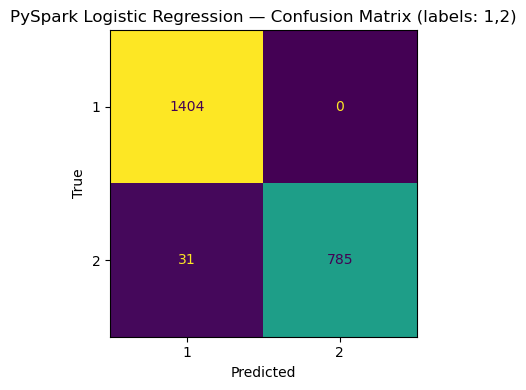

In [31]:
# Part B.4.1.b.

# CLASSIFICATION

t = time.perf_counter()

# For this conversion, Arrow can spike memory; turn it off:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")

# Align to non-missing label
mask_clf = y_clf_bin.notna()
X_clf_pd = X_encoded_df.loc[mask_clf].copy()
y_clf_clean = y_clf_bin.loc[mask_clf].astype(int).reset_index(drop=True)

# 1) Convert dense OHE to sparse CSR
X_csr = sparse.csr_matrix(X_clf_pd.values)   # shape: (n_rows, n_feats)
n_feats = X_csr.shape[1]

# 2) Generate rows lazily as (label, features=SparseVector)
def gen_rows_cls():
    for i in range(X_csr.shape[0]):
        start, end = X_csr.indptr[i], X_csr.indptr[i+1]
        idx = X_csr.indices[start:end].astype(int)
        data = X_csr.data[start:end].astype(float)
        yield Row(label=int(y_clf_clean.iloc[i]),
                  features=Vectors.sparse(n_feats, idx, data))

from pyspark.sql.types import StructType, StructField
cls_schema = StructType([
    StructField("label", IntegerType(), nullable=False),
    StructField("features", VectorUDT(), nullable=False),
])

cls_sdf = spark.createDataFrame(gen_rows_cls(), schema=cls_schema).repartition(4)
# repartition to spread memory/compute; tune 4 to your cores

# Split (train=80%, test=20%)
train_cls_sdf, test_cls_sdf = cls_sdf.randomSplit([0.8, 0.2], seed=42)

# Logistic Regression
spark_logreg = SparkLogisticRegression(
    featuresCol="features",
    labelCol="label",
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    maxIter=1200
)
log_model = spark_logreg.fit(train_cls_sdf)

cls_pred = log_model.transform(test_cls_sdf).select("label", "prediction")

# Confusion matrix counts purely in Spark (no big collects)
cm_counts = (
    cls_pred.groupBy("label", "prediction")
            .agg(F.count("*").alias("cnt"))
)

# Bring back the tiny 2x2 (max 4 rows) result safely
cm_pd = (
    cm_counts.toPandas()
    .pivot(index="label", columns="prediction", values="cnt")
    .fillna(0)
    .astype(int)
    .reindex(index=[1,2], columns=[1,2], fill_value=0)
)

TN = int(cm_pd.loc[1,1]); FP = int(cm_pd.loc[1,2])
FN = int(cm_pd.loc[2,1]); TP = int(cm_pd.loc[2,2])
total = TN + FP + FN + TP

acc  = (TP + TN) / total if total else 0.0
prec = TP / (TP + FP) if (TP + FP) else 0.0
rec  = TP / (TP + FN) if (TP + FN) else 0.0
f1   = (2*prec*rec)/(prec+rec) if (prec+rec) else 0.0

# Ensure 2x2 order and int dtype
cm_ordered = (
    cm_pd.reindex(index=[1, 2], columns=[1, 2], fill_value=0)
         .astype(int)
         .values
)

fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ordered, display_labels=[1, 2])
disp.plot(ax=ax,  cmap="viridis", colorbar=False)  # rows=true, cols=pred (as built)
ax.set_title("PySpark Logistic Regression — Confusion Matrix (labels: 1,2)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.tight_layout()
plt.show()

duration_sec_spark_logr = time.perf_counter() - t

#### Part B.4.2. Compare results with Scikit-Learn (accuracy, scalability, and speed)

In [32]:
# Part B.4.2.a.

# LINEAR REGRESSION - Compare Accuracy

w = max(
    len("Scikit OLS MSE"),
    len("Scikit OLS RMSE"),
    len("Scikit OLS MAE"),
    len("Scikit OLS R2"),
    len("Spark MLlib OLS MSE"),
    len("Spark MLlib OLS RMSE"),
    len("Spark MLlib OLS MAE"),
    len("Spark MLlib OLS R2"),
)

numw = 10  # width for the numeric column
fmt = f"{{:<{w}}} : {{:>{numw}.4f}}"  # SAME pattern for every line

print(fmt.format("Scikit OLS MSE",  mse_ols))
print(fmt.format("Scikit OLS RMSE", rmse_ols))
print(fmt.format("Scikit OLS MAE",  mae_ols))
print(fmt.format("Scikit OLS R2",   r2_ols))
print("---")
print(fmt.format("Spark MLlib OLS MSE",  mse_ols_ps))
print(fmt.format("Spark MLlib OLS RMSE", rmse_ols_ps))
print(fmt.format("Spark MLlib OLS MAE",  mae_ols_ps))
print(fmt.format("Spark MLlib OLS R2",   r2_ols_ps))


Scikit OLS MSE       :     0.0003
Scikit OLS RMSE      :     0.0168
Scikit OLS MAE       :     0.0104
Scikit OLS R2        :     0.9987
---
Spark MLlib OLS MSE  :     0.0326
Spark MLlib OLS RMSE :     0.1804
Spark MLlib OLS MAE  :     0.0907
Spark MLlib OLS R2   :     0.8514


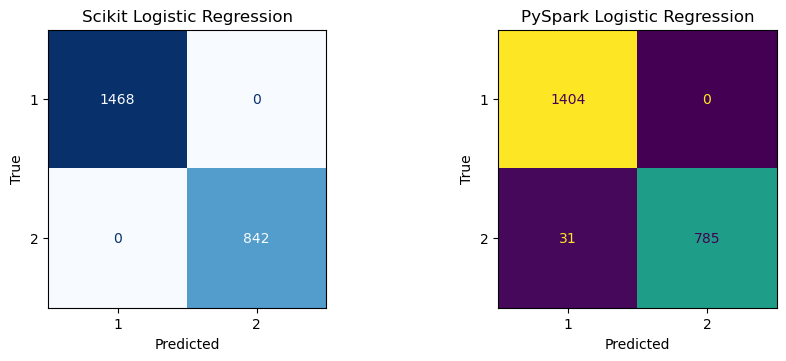

In [33]:
# Part B.4.2.b.

# LOGISTIC REGRESSION - Compare Accuracy

fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), constrained_layout=True)

# Scikit Logistic Regression
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2])
disp1.plot(ax=axes[0], cmap="Blues", colorbar=False, values_format="d")
axes[0].set_title("Scikit Logistic Regression")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# PySpark Logistic Regression
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_ordered, display_labels=[1, 2])
disp2.plot(ax=axes[1], cmap="viridis", colorbar=False, values_format="d")
axes[1].set_title("PySpark Logistic Regression")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.show()

In [34]:
# Part B.4.2.c.

# LINEAR/LOGISTIC REGRESSIONS - Compare Speed (Duration)

w = max(
    len("Total Duration (Scikit Linear Regression)"),
    len("Total Duration (Scikit Logistic Regression)"),
    len("Total Duration (Spark MLlib Linear Regression)"),
    len("Total Duration (Spark MLlib Logistic Regression)")
)
print(f"{'Total Duration (Scikit Linear Regression)':<{w}} : {float(duration_sec_linr):.4f} secs")
print(f"{'Total Duration (Scikit Logistic Regression)':<{w}} : {float(duration_sec_logr):.4f} secs")
print(f"{'Total Duration (Spark MLlib Linear Regression)':<{w}} : {float(duration_sec_spark_linr):.4f} secs")
print(f"{'Total Duration (Spark MLlib Logistic Regression)':<{w}} : {float(duration_sec_spark_logr):.4f} secs")

Total Duration (Scikit Linear Regression)        : 3.6306 secs
Total Duration (Scikit Logistic Regression)      : 211.0409 secs
Total Duration (Spark MLlib Linear Regression)   : 20.5891 secs
Total Duration (Spark MLlib Logistic Regression) : 15.5339 secs


# Part C – Reproducibility and Workflow

<div class="callout note">
  <p><strong>Part C – Reproducibility and Workflow</strong></p>
<p>
Please follow the scripts below:
  <ul>
    <li><em>A1_Pipeline.ipynb</em> - The pipeline to run the machine learning codes.</li>
    <li><em>Collaborator_run.ipynb</em> - For collaborators to clone and run the pipeline locally in their own environments (reproducible).</li>
  </ul>
</p>
</div>